## Introduction

Experiments were conducted to find an optimal machine learning model.

## Description


Data Distribution 
>- Data from 1991 to 2005 was selected as training data and data from 2006 to 2012 was used as testing data. This distribution was selected as these years were suggested by the [ones](https://github.com/JarFraud/FraudDetection) who created this data.
>- Do different types of data, with same distribution were used through out the experiments:
>>- Raw dataset: contained raw data from Cecchini columns. 
>>- Ratio dataset: contained 54 ratios and 2 flags.

Random Models:
>- Different classfication models were experimented to find which might work best.
>- Random Forest and Single Decision Tree doesnt seem to work. One of the reason was extreme imbalance in the data.

RUSBoost:
>- As suggested by the paper, we went for RUSBoost. We found the [repo](https://github.com/JarFraud/FraudDetection) but the implementation was in Matlab. The outcome of the Matlab was not satisfactory, and the only metric used was AUC, with 0.725 being the best model, as seen on this [website](https://onlinelibrary.wiley.com/doi/full/10.1111/1475-679X.12292). 
>- RUSBoost was trained on both datasets with different base estimators. Learning_rate = 0.1, random_state = 42,min_ratio = 3 was used so the results were comparable. weight = sum(y_train == 0)/sum(y_train == 1) was used for class imbalance :
>>- First base estimator used was Decision Tree. For this different number of estimators were used [500-3000] to train both datasets and results were observed using both confusion matrix and the plot of True Positive Rate / False Positive Rate.
>>>- With the increase of estimators, both TPR and FPR increased, showing direct relationship.
>>>- With 900 estimatores, best result for Raw data was TPR:0.607527 and FPR:0.361023. For Ratios the best results were TPR:0.768817 and FPR:0.514670 for 950 estimators.
>>>- Max AUC we got was 0.679101 and that was for Ratio Dataset with TPR:0.005376 and FPR:0.001103. 
>>- Second base estimator used was Random Forest
>>>- With 600 estimators, best result for both Raw data and Ratio data was TPR:0.790323 and FPR:0.468147.
>>>- Max AUC we got for both was 0.734276 at for TPR:0.844086 and FPR:0.560807.
>>- If we only consider AUC, RUSBoost with Random Forest as base estimator outperformed Decision tree as well as the model in the paper. But I highly doubt that this model is good enough.
>- To see whether this model was good enough, we chose the best RUSBoost model (600 estimators) and plot histogram for False Positive Rate per bin and it seems, it depicted random nature.

Correlation Analysis:
>- Brief correlation analysis for the ratio dataset was done at the end.

## Conclusions

>- Our data is highly imbalance due to which performing normal machine learning task might be difficult. 
>- Normal machine learning models perform well on balanced data due to which we had 2 options either over-sampling or under-sampling. 
>- Since, we did not want to create synthetic data for fraud cases, RUSBoost seems to be a good option that uses random under sampling and AdaBoost model. The paper showed RUSBoost as a good model but, by using only AUC as the metric. 
>- As shown in above results, the model with best AUC didn't necessarily performed well and with further analysis it seems it was not a good metric. A good model will have good AUC but a model with AUC will not necessarily will have good performance.
> -But some further analysis was conducted on RUSBoost in RUSBoost_experiments notebook.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
import sklearn.metrics as metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from RUSBoost.rusboost import *
%matplotlib inline

All files are imported


C:\Users\umaid\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\umaid\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# Reading raw data
df_raw = pd.read_csv('../Dataset/university_data/uni_fraud.csv',sep = ';')
df_c = df_raw[['g_id','fyear','fraud','act', 'ap', 'at', 'ceq', 'che', 'cogs', 'csho', 'dlc', 'dltis', 'dltt', 'dp', 'ib', 'invt', 'ivao', 'ivst', 'lct', 'lt', 'ni', 'ppegt', 'pstk', 're', 'rect', 'sale', 'sstk', 'txp', 'txt', 'xint', 'prcc_f']]
df_c.head()

,g_id,fyear,fraud,act,ap,at,ceq,che,cogs,csho,...,ppegt,pstk,re,rect,sale,sstk,txp,txt,xint,prcc_f
0,100001990,1990.0,0.0,320.933,32.721,422.099,151.035,15.801,309.272,13.120,...,127.824,0.0,124.587,81.173,507.820,0.012,0.561,1.932,18.941,7.625
1,100001991,1991.0,0.0,291.493,33.937,392.755,155.328,24.042,338.654,13.122,...,132.961,0.0,128.735,78.314,534.808,0.020,0.493,1.177,17.172,9.875
2,100001992,1992.0,0.0,265.317,27.145,374.930,161.128,17.025,336.882,13.122,...,144.461,0.0,134.430,83.788,535.553,0.020,1.762,1.942,12.339,13.375
3,100001993,1993.0,0.0,303.795,41.373,423.337,178.183,12.356,363.065,13.305,...,155.862,0.0,149.559,97.754,582.851,5.086,4.617,8.207,12.344,26.375
4,100001994,1994.0,0.0,335.913,31.559,469.387,195.089,8.814,404.679,13.121,...,167.356,0.0,169.856,117.002,640.810,0.538,0.000,11.732,12.288,19.625


In [4]:
# Any missing values in cecchini columns
df_c.isnull().sum().sum()

0

In [25]:
# Reading ratio data
df = pd.read_csv("Dataset/uni_ratios_fraud.csv",sep = ';')
df.head()

,g_id,fyear,gvkey,fraud,sale_flag,at_flag,sale/at,at/sale,act/sale,act/at,...,sstk/sale,sstk/at,txp/sale,txp/at,txt/sale,txt/at,xint/sale,xint/at,prcc_f/sale,prcc_f/at
0,100001990,1990.0,10000.0,0.0,0,0,1.203083,0.831198,0.631982,0.760326,...,0.000024,0.000028,0.001105,0.001329,0.003804,0.004577,0.037299,0.044873,0.015015,0.018064
1,100001991,1991.0,10000.0,0.0,0,0,1.361683,0.734385,0.545042,0.742175,...,0.000037,0.000051,0.000922,0.001255,0.002201,0.002997,0.032109,0.043722,0.018465,0.025143
2,100001992,1992.0,10000.0,0.0,0,0,1.428408,0.700080,0.495408,0.707644,...,0.000037,0.000053,0.003290,0.004700,0.003626,0.005180,0.023040,0.032910,0.024974,0.035673
3,100001993,1993.0,10000.0,0.0,0,0,1.376801,0.726321,0.521222,0.717620,...,0.008726,0.012014,0.007921,0.010906,0.014081,0.019386,0.021179,0.029159,0.045252,0.062303
4,100001994,1994.0,10000.0,0.0,0,0,1.365206,0.732490,0.524201,0.715642,...,0.000840,0.001146,0.000000,0.000000,0.018308,0.024994,0.019176,0.026179,0.030625,0.041810


In [6]:
# Any missing values in our dataset
df.isnull().sum().sum()

0

In [121]:
# Seperating Fraud flags
# y = df['fraud']
# X = df.drop('fraud', axis=1)

In [122]:
# y_fraud = y[y==1]
# idx = y_fraud.index.tolist()
# X_fraud = X[X.index.isin(idx)] 

In [123]:
# y_nonfraud = y[y==0]
# idx = y_nonfraud.index.tolist()
# X_nonfraud = X[X.index.isin(idx)] 

In [124]:
# X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(X_fraud, y_fraud, test_size = 0.2)

In [125]:
# X_nonfraud_train, X_nonfraud_test, y_nonfraud_train, y_nonfraud_test = train_test_split(X_nonfraud, y_nonfraud, test_size = 0.9)

In [126]:
# X_train = pd.concat([X_nonfraud_train,X_fraud_train])
# y_train = pd.concat([y_nonfraud_train,y_fraud_train])
# # X_train = (X_train/X_train.mean(axis = 0))
# X_train = X_train.iloc[:,3:]
# X_train

In [127]:
# X_test = pd.concat([X_nonfraud_test,X_fraud_test])
# y_test = pd.concat([y_nonfraud_test,y_fraud_test])
# # X_test = (X_test/X_test.mean(axis = 0))
# X_test = X_test.iloc[:,3:]
# X_test

In [128]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [52]:
df_c.fyear.unique()

array([1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997., 1998.,
       1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007.,
       2008., 2009., 2010., 2011., 2012., 2014., 2013.])

### Pre-Processing Data

In [84]:
df_c.fyear.unique()

array([1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997., 1998.,
       1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007.,
       2008., 2009., 2010., 2011., 2012., 2014., 2013.])

In [78]:
# According to data providers, Cecchini and Dechow, 1991-2005 is the best years.
years = np.arange(1991,2006)
test_years = np.arange(2006,2013)

In [70]:
# Splitting Data
X_train = df[df.fyear.isin(years)]
X_raw_train = df_c[df_c.fyear.isin(years)]

y_train = X_train.fraud
y_raw_train = X_raw_train.fraud

X_train.drop(['g_id','fyear','gvkey','fraud'],axis = 1,inplace = True)
X_raw_train.drop(['g_id','fyear','fraud'],axis = 1,inplace = True)

In [79]:
X_test = df[df.fyear.isin(test_years)]
X_raw_test = df_c[df_c.fyear.isin(test_years)]

y_test = X_test.fraud
y_raw_test = X_raw_test.fraud

X_test.drop(['g_id','fyear','gvkey','fraud'],axis = 1,inplace = True)
X_raw_test.drop(['g_id','fyear','fraud'],axis = 1,inplace = True)

In [80]:
# Rescaling data
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler_raw = preprocessing.StandardScaler().fit(X_raw_train)
X_raw_train = scaler_raw.transform(X_raw_train)
X_raw_test = scaler_raw.transform(X_raw_test)

In [81]:
# Training data composition
print('Non Fraud cases in Training set:',sum(y_train == 0))
print('Fraud cases in Training set:',sum(y_train == 1))

Non Fraud cases in Training set: 94830
Fraud cases in Training set: 763


In [82]:
# Testing data composition
print('Non Fraud cases in Testing set:',sum(y_test == 0))
print('Fraud cases in Testing set:',sum(y_test == 1))

Non Fraud cases in Testing set: 38992
Fraud cases in Testing set: 186


### SVM

In [25]:
# from sklearn.svm import SVC
# svclassifier = SVC(kernel='linear',C=30)

In [26]:
# svclassifier.fit(X_train, y_train)

In [27]:
# y_pred = svclassifier.predict(X_test)

In [28]:
# print(confusion_matrix(y_test,y_pred).ravel())
# print(classification_report(y_test,y_pred))

### Single Decision Tree

In [28]:
weight = sum(y_train == 0)/sum(y_train == 1)
weights = {0:1, 1:weight}

##### Ratios

In [30]:
model = DecisionTreeClassifier(class_weight = weights)
model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0,
                       class_weight={0: 1, 1: 120.67245989304813},
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

In [31]:
y_pred = model.predict(X_test)

In [32]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[38659   333]
 [  179     7]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     38992
         1.0       0.02      0.04      0.03       186

    accuracy                           0.99     39178
   macro avg       0.51      0.51      0.51     39178
weighted avg       0.99      0.99      0.99     39178



##### Raw Data

In [33]:
model = DecisionTreeClassifier(class_weight = weights)
model.fit(X_raw_train,y_raw_train)

DecisionTreeClassifier(ccp_alpha=0.0,
                       class_weight={0: 1, 1: 120.67245989304813},
                       criterion='gini', max_depth=None, max_features=None,
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

In [34]:
y_pred = model.predict(X_raw_test)

In [35]:
print(confusion_matrix(y_raw_test,y_pred))
print(classification_report(y_raw_test,y_pred))

[[38641   351]
 [  182     4]]
              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     38992
         1.0       0.01      0.02      0.01       186

    accuracy                           0.99     39178
   macro avg       0.50      0.51      0.50     39178
weighted avg       0.99      0.99      0.99     39178



### Random Forest

In [63]:
# train model
rfc = RandomForestClassifier(n_estimators=50,class_weight=weights).fit(X_train, y_train)

# predict on test set
y_pred = rfc.predict(X_test)

In [64]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[38992     0]
 [  186     0]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38992
         1.0       0.00      0.00      0.00       186

    accuracy                           1.00     39178
   macro avg       0.50      0.50      0.50     39178
weighted avg       0.99      1.00      0.99     39178



C:\Users\umaid\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### RUSBoost with DecisionTree

##### Test

In [505]:
rus = RUSBoost(n_estimators=900,learning_rate = 0.1, random_state = 42,min_ratio = 3)

In [506]:
rus.fit(X_raw_train,y_raw_train)

C:\Users\umaid\anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


RUSBoost(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
         min_ratio=2.5, n_estimators=900, n_samples=0, random_state=42,
         with_replacement=None)

In [508]:
y_raw_pred = rus.predict(X_raw_test)

In [509]:
print(confusion_matrix(y_raw_test,y_raw_pred))
print(classification_report(y_raw_test,y_raw_pred))

[[24914 14078]
 [   73   113]]
              precision    recall  f1-score   support

         0.0       1.00      0.64      0.78     38992
         1.0       0.01      0.61      0.02       186

    accuracy                           0.64     39178
   macro avg       0.50      0.62      0.40     39178
weighted avg       0.99      0.64      0.78     39178



##### Raw Data

In [26]:
# function to calculate 
def rates(y_test,y_pred):
    mat = confusion_matrix(y_test,y_pred)
    TPR = mat[1,1]/(mat[1,1] + mat[1,0]) # Senstivity (True positive rate)
    FPR = mat[0,1]/(mat[0,1]+mat[0,0]) # 1-Specificity (False positive rate)
    return([TPR,FPR])

In [39]:
# checking for different estimators number
# used random seed as 42 for consistent results
# used min_ratio to reduce false positives

ROC = {'TPR':[],'FPR':[],'EST':[]}
for estimators in np.arange(500,3001,50):
    print('Estimators:',estimators)
    rus = RUSBoost(n_estimators=estimators,learning_rate = 0.1, random_state = 42,min_ratio = 2.5)
    rus.fit(X_raw_train,y_raw_train,minority_target=1)
    y_raw_pred = rus.predict(X_raw_test)
    rates_list = rates(y_raw_test,y_raw_pred)
    ROC['TPR'].append(rates_list[0])
    ROC['FPR'].append(rates_list[1])
    ROC['EST'].append(estimators)


Estimators: 500
Estimators: 550
Estimators: 600
Estimators: 650
Estimators: 700
Estimators: 750
Estimators: 800
Estimators: 850
Estimators: 900
Estimators: 950
Estimators: 1000
Estimators: 1050
Estimators: 1100
Estimators: 1150
Estimators: 1200
Estimators: 1250
Estimators: 1300
Estimators: 1350
Estimators: 1400
Estimators: 1450
Estimators: 1500
Estimators: 1550
Estimators: 1600
Estimators: 1650
Estimators: 1700
Estimators: 1750
Estimators: 1800
Estimators: 1850
Estimators: 1900
Estimators: 1950
Estimators: 2000
Estimators: 2050
Estimators: 2100
Estimators: 2150
Estimators: 2200
Estimators: 2250
Estimators: 2300
Estimators: 2350
Estimators: 2400
Estimators: 2450
Estimators: 2500
Estimators: 2550
Estimators: 2600
Estimators: 2650
Estimators: 2700
Estimators: 2750
Estimators: 2800
Estimators: 2850
Estimators: 2900
Estimators: 2950
Estimators: 3000


In [40]:
ROC = pd.DataFrame(ROC)
ROC

,TPR,FPR,EST
0,0.026882,0.020235,500
1,0.032258,0.021363,550
2,0.037634,0.020261,600
3,0.037634,0.024133,650
4,0.037634,0.034007,700
5,0.080645,0.047779,750
6,0.112903,0.075503,800
7,0.172043,0.113177,850
8,0.607527,0.361023,900
9,0.795699,0.607278,950


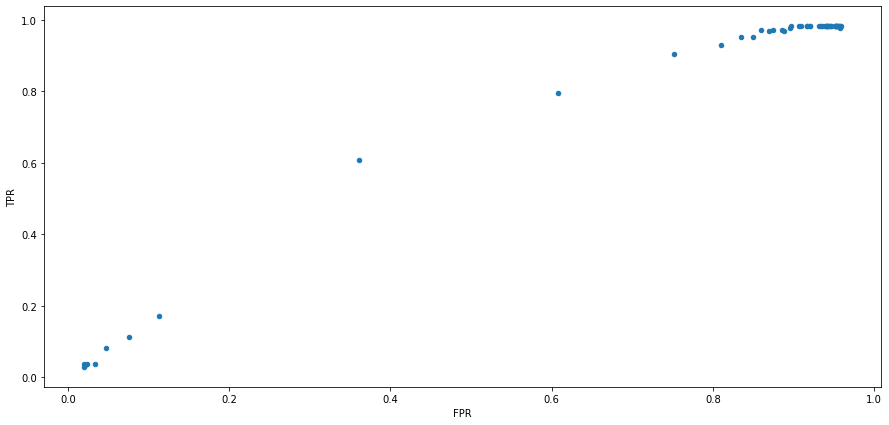

In [41]:
ROC.plot.scatter(y ='TPR',x ='FPR',figsize = (15,7))

##### Ratios

In [28]:
ROC_ratio = {'TPR':[],'FPR':[],'EST':[],'AUC':[]}
for estimators in np.arange(500,3001,50):
    print('Estimators:',estimators)
    rus = RUSBoost(n_estimators=estimators,learning_rate = 0.1,random_state = 42,min_ratio = 2.5)
    rus.fit(X_train,y_train,minority_target=1)
    y_pred = rus.predict(X_test)
    probs = rus.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    rates_list = rates(y_test,y_pred)
    ROC_ratio['TPR'].append(rates_list[0])
    ROC_ratio['FPR'].append(rates_list[1])
    ROC_ratio['EST'].append(estimators)
    ROC_ratio['AUC'].append(roc_auc)

Estimators: 500
Estimators: 550
Estimators: 600
Estimators: 650
Estimators: 700
Estimators: 750
Estimators: 800
Estimators: 850
Estimators: 900
Estimators: 950
Estimators: 1000
Estimators: 1050
Estimators: 1100
Estimators: 1150
Estimators: 1200
Estimators: 1250
Estimators: 1300
Estimators: 1350
Estimators: 1400
Estimators: 1450
Estimators: 1500
Estimators: 1550
Estimators: 1600
Estimators: 1650
Estimators: 1700
Estimators: 1750
Estimators: 1800
Estimators: 1850
Estimators: 1900
Estimators: 1950
Estimators: 2000
Estimators: 2050
Estimators: 2100
Estimators: 2150
Estimators: 2200
Estimators: 2250
Estimators: 2300
Estimators: 2350
Estimators: 2400
Estimators: 2450
Estimators: 2500
Estimators: 2550
Estimators: 2600
Estimators: 2650
Estimators: 2700
Estimators: 2750
Estimators: 2800
Estimators: 2850
Estimators: 2900
Estimators: 2950
Estimators: 3000


In [29]:
ROC_ratio = pd.DataFrame(ROC_ratio)
ROC_ratio

,TPR,FPR,EST,AUC
0,0.005376,0.001103,500,0.679101
1,0.010753,0.006771,550,0.674152
2,0.086022,0.031776,600,0.674397
3,0.096774,0.049626,650,0.676949
4,0.134409,0.078478,700,0.670939
5,0.172043,0.108612,750,0.661080
6,0.258065,0.147030,800,0.656632
7,0.387097,0.233638,850,0.660838
8,0.666667,0.412521,900,0.668885
9,0.768817,0.514670,950,0.665383


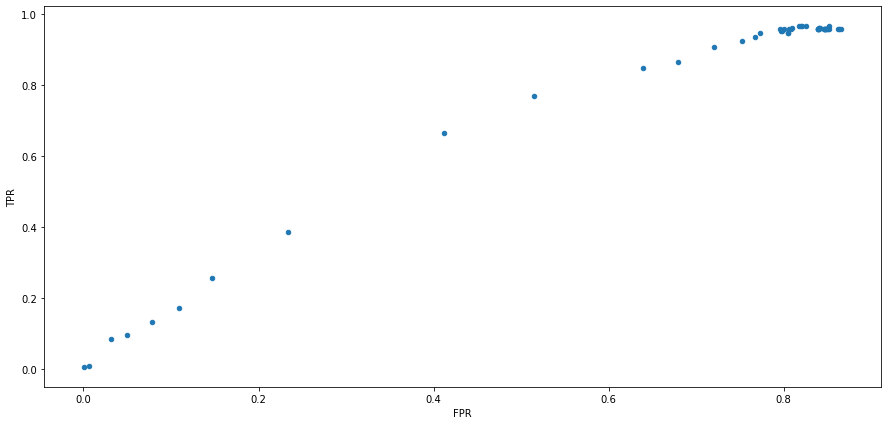

In [30]:
ROC_ratio.plot.scatter(y ='TPR',x ='FPR',figsize = (15,7))

### RUSBoost with RandomForest

#### Raw Data

In [99]:
ROC = {'TPR':[],'FPR':[],'EST':[],'AUC':[]}
for estimators in np.arange(200,1501,50):
    print('Estimators:',estimators)
    rus = RUSBoost(base_estimator = RandomForestClassifier(n_estimators = 2,class_weight = weights,max_depth = 5),n_estimators=estimators,learning_rate = 0.1,random_state = 42,min_ratio = 3)
    rus.fit(X_raw_train,y_raw_train,minority_target=1)
    y_raw_pred = rus.predict(X_raw_test)
    probs = rus.predict_proba(X_raw_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_raw_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    rates_list = rates(y_raw_test,y_raw_pred)
    ROC['TPR'].append(rates_list[0])
    ROC['FPR'].append(rates_list[1])
    ROC['EST'].append(estimators)
    ROC['AUC'].append(roc_auc)

Estimators: 200
Estimators: 250
Estimators: 300
Estimators: 350
Estimators: 400
Estimators: 450
Estimators: 500
Estimators: 550
Estimators: 600
Estimators: 650
Estimators: 700
Estimators: 750
Estimators: 800
Estimators: 850
Estimators: 900
Estimators: 950
Estimators: 1000
Estimators: 1050
Estimators: 1100
Estimators: 1150
Estimators: 1200
Estimators: 1250
Estimators: 1300
Estimators: 1350
Estimators: 1400
Estimators: 1450
Estimators: 1500


In [105]:
ROC = pd.DataFrame(ROC)
ROC.sort_values('TPR')

,TPR,FPR,EST,AUC
3,0.467742,0.219224,200,0.701253
2,0.473118,0.200785,150,0.701757
0,0.478495,0.219148,50,0.706582
1,0.478495,0.197964,100,0.707763
4,0.505376,0.243922,250,0.700541
5,0.564516,0.271876,300,0.709795
6,0.602151,0.299831,350,0.718775
7,0.629032,0.330632,400,0.716067
8,0.639785,0.362690,450,0.714400
9,0.682796,0.398825,500,0.717166


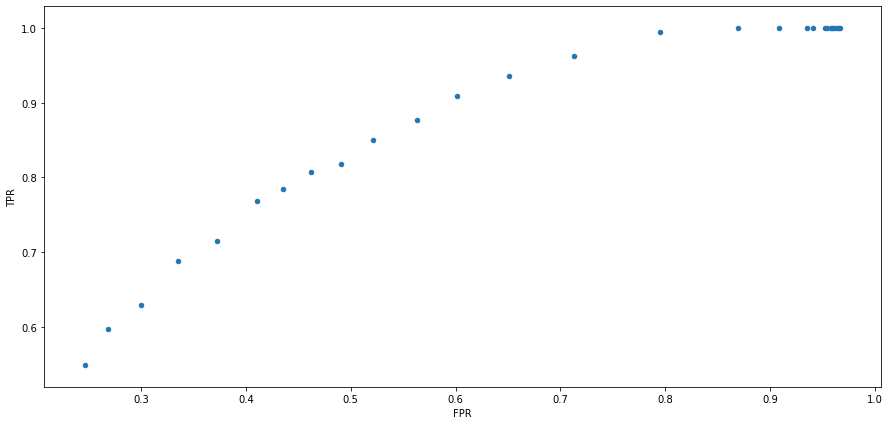

In [101]:
ROC.plot.scatter(y ='TPR',x ='FPR',figsize = (15,7))

#### Ratios

In [102]:
ROC = {'TPR':[],'FPR':[],'EST':[],'AUC':[]}
for estimators in np.arange(50,1501,50):
    print('Estimators:',estimators)
    rus = RUSBoost(base_estimator = RandomForestClassifier(n_estimators = 2,class_weight = weights,max_depth = 5),n_estimators=estimators,learning_rate = 0.1,random_state = 42,min_ratio = 3)
    rus.fit(X_train,y_train,minority_target=1)
    y_pred = rus.predict(X_test)
    probs = rus.predict_proba(X_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    rates_list = rates(y_test,y_pred)
    ROC['TPR'].append(rates_list[0])
    ROC['FPR'].append(rates_list[1])
    ROC['EST'].append(estimators)
    ROC['AUC'].append(roc_auc)

Estimators: 50
Estimators: 100
Estimators: 150
Estimators: 200
Estimators: 250
Estimators: 300
Estimators: 350
Estimators: 400
Estimators: 450
Estimators: 500
Estimators: 550
Estimators: 600
Estimators: 650
Estimators: 700
Estimators: 750
Estimators: 800
Estimators: 850
Estimators: 900
Estimators: 950
Estimators: 1000
Estimators: 1050
Estimators: 1100
Estimators: 1150
Estimators: 1200
Estimators: 1250
Estimators: 1300
Estimators: 1350
Estimators: 1400
Estimators: 1450
Estimators: 1500


In [103]:
ROC = pd.DataFrame(ROC)
ROC

,TPR,FPR,EST,AUC
0,0.478495,0.219148,50,0.706582
1,0.478495,0.197964,100,0.707763
2,0.473118,0.200785,150,0.701757
3,0.467742,0.219224,200,0.701253
4,0.505376,0.243922,250,0.700541
5,0.564516,0.271876,300,0.709795
6,0.602151,0.299831,350,0.718775
7,0.629032,0.330632,400,0.716067
8,0.639785,0.362690,450,0.714400
9,0.682796,0.398825,500,0.717166


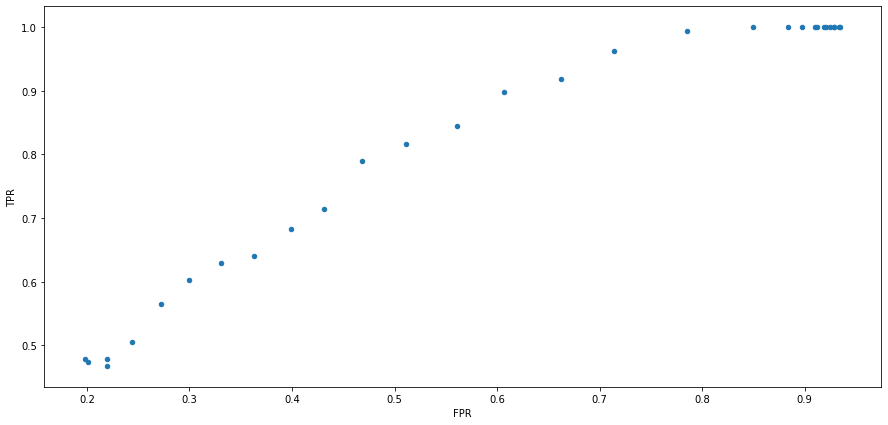

In [104]:
ROC.plot.scatter(y ='TPR',x ='FPR',figsize = (15,7))

#### Conclusion : Adaboost with random forest as base estimator out performed desicion trees as base estimator

### FPR/TPR Histogram/Analysis

In [144]:
# Chose the best model
rus = RUSBoost(base_estimator = RandomForestClassifier(n_estimators = 2,class_weight = weights,max_depth = 5),n_estimators=600,learning_rate = 0.1,random_state = 42,min_ratio = 3)
rus.fit(X_train,y_train,minority_target=1)
y_pred = rus.predict(X_test)
probs = rus.predict_proba(X_test)

In [145]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[20860 18132]
 [   38   148]]
              precision    recall  f1-score   support

         0.0       1.00      0.53      0.70     38992
         1.0       0.01      0.80      0.02       186

    accuracy                           0.54     39178
   macro avg       0.50      0.67      0.36     39178
weighted avg       0.99      0.54      0.69     39178



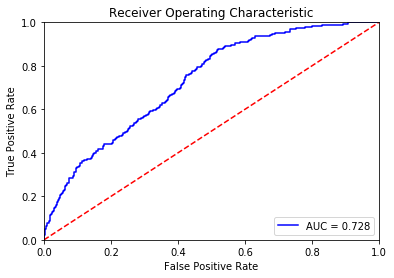

In [147]:
fpr, tpr, threshold = metrics.roc_curve(y_test, probs[:,1])
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = f'AUC = {round(roc_auc,3)}')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [148]:
prob_df = pd.DataFrame({'class':y_test,'probs':probs[:,1],'pred':y_pred})

In [149]:
fpr_df = prob_df[(prob_df['pred'] == 1)]
fpr_df.head()

,class,probs,pred
16,0.0,0.539093,1.0
17,0.0,0.559975,1.0
18,0.0,0.570736,1.0
19,0.0,0.554903,1.0
20,0.0,0.516745,1.0


In [150]:
def bins_edges(bin_size = 0.01,min_edge = 0.5,max_edge = 1):
    bin_size = bin_size; min_edge = min_edge; max_edge = max_edge
    N = (max_edge-min_edge)/bin_size; Nplus1 = round(N) + 1
    bins = np.linspace(min_edge, max_edge, Nplus1)
    return bins

In [151]:
def bars(df = fpr_df,cls = 0, bins = bins_edges()):
    groups = df.groupby(pd.cut(fpr_df.probs, bins = bins))
    FPR_list = list()
    for grp in groups:
        grp = pd.DataFrame(grp[1])
        if grp.empty:
            FPR_list.append(0)  
        else:
            FPR = grp[grp['class'] == cls].shape[0]/grp.shape[0]
            FPR_list.append(FPR)
    return FPR_list

In [152]:
# def plot_hist(df=fpr_df,cls = 0,bin_size = 0.1,title=None,xlabel=None,ylabel=None):
#     bins = bins_edges(bin_size = bin_size)
#     height = bars(df = df,bins = bins,cls = cls)
#     fig, ax = plt.subplots(figsize=(15, 7))
#     str_bin = [str(round(x,2)) for x in bins[:-1]]
#     ax.bar(str_bin,height,align='edge',width = 0.9)
#     ax.tick_params(axis='x', rotation=45)
    
#     if title:
#         ax.set_title(title)
#     if xlabel:
#         ax.set_ylabel(ylabel)
#     if ylabel:
#         ax.set_xlabel(xlabel)

In [153]:
def plot_hist(df=fpr_df,cls = 0,bin_size = 0.1,title=None,xlabel=None,ylabel=None):
    import matplotlib
    
    bins = bins_edges(bin_size = bin_size)
    heights = bars(df = df,bins = bins,cls = cls)
    fig, ax = plt.subplots(figsize=(23, 10))
    str_bin = [str(round(x,2)) for x in bins[:-1]]
    rects = ax.bar(str_bin,heights,align='edge',width = 0.9)
    ax.set_xticks(str_bin)
    ax.tick_params(axis='x', rotation=45)
    
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_ylabel(ylabel)
    if ylabel:
        ax.set_xlabel(xlabel)
        
    
    for k , rect in enumerate(rects):
        height = rect.get_height()
        rat = heights[k]
        if rat > 0.1:
            rat = round(rat,2)
        else:
            rat = round(rat,3)
        if rat == 0:
            continue
        ax.text(rect.get_x() + rect.get_width()/2, height, f'{rat}', ha='center', va='bottom',fontsize=13,rotation = 60)
#         matplotlib.rcParams.update({'font.size': 12})
#     plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

#     plt.grid()
    plt.show()

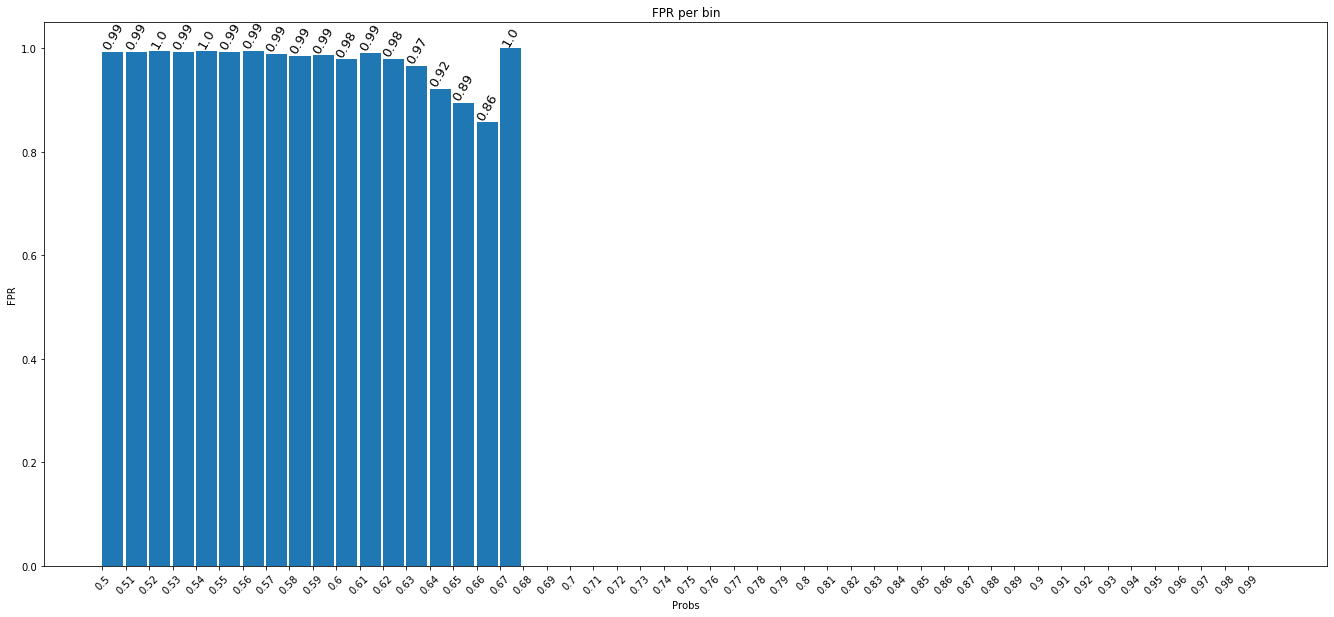

In [154]:
plot_hist(df=fpr_df,bin_size = 0.01,title = 'FPR per bin', xlabel = 'Probs', ylabel = 'FPR')

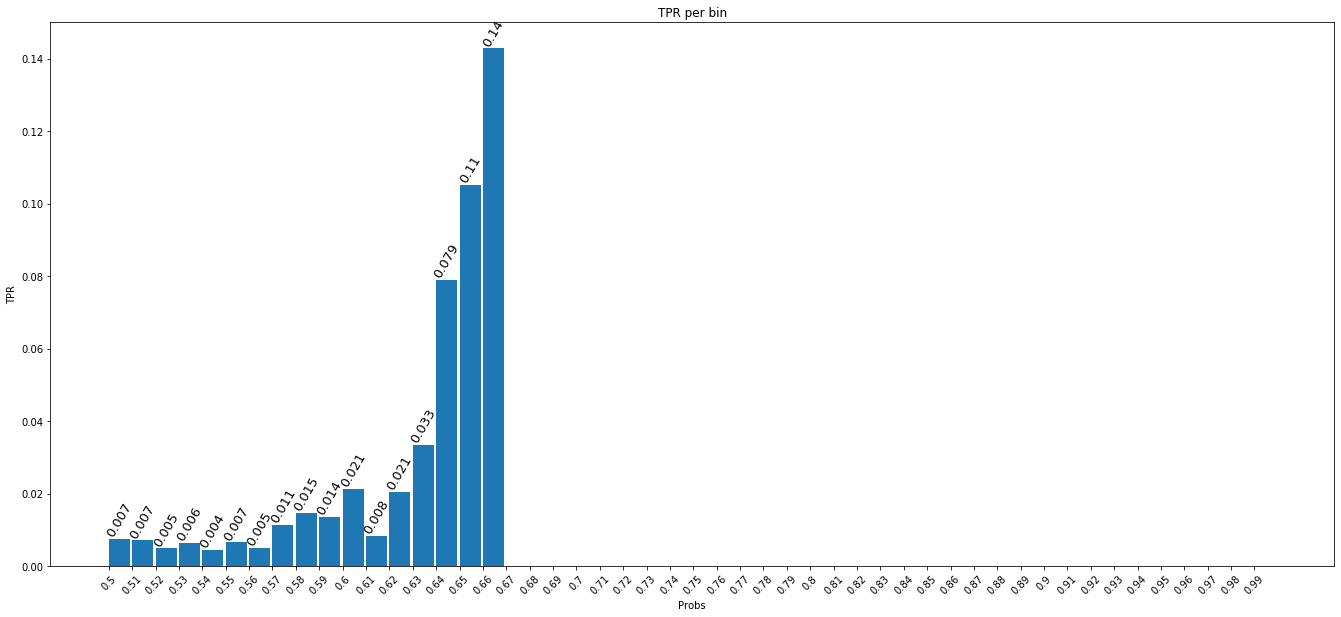

In [155]:
plot_hist(df=fpr_df,cls = 1,bin_size = 0.01,title = 'TPR per bin', xlabel = 'Probs', ylabel = 'TPR')

Text(0.5, 0, 'Probs')

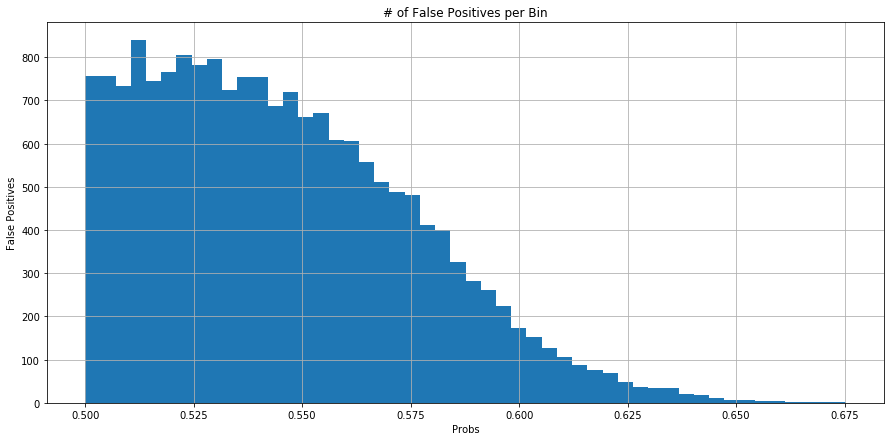

In [156]:
ax = fpr_df[fpr_df['class'] == 0].probs.hist(figsize = (15,7),bins = 50)
ax.set_title('# of False Positives per Bin')
ax.set_ylabel('False Positives')
ax.set_xlabel('Probs')

Text(0.5, 0, 'Probs')

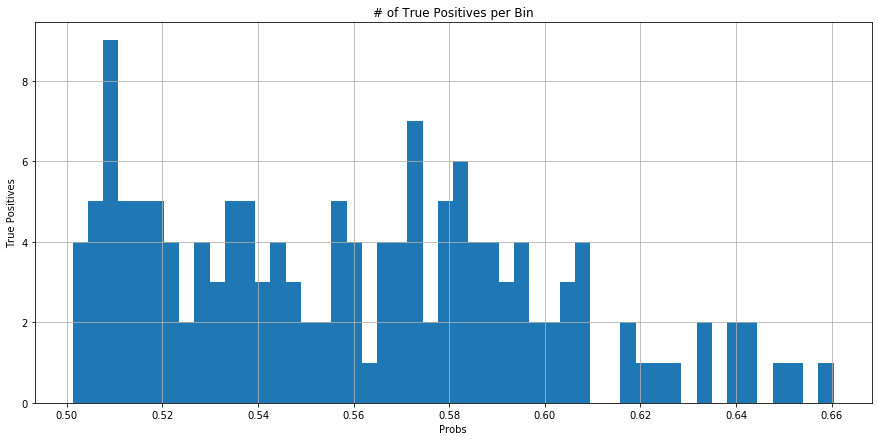

In [157]:
ax = fpr_df[fpr_df['class'] == 1].probs.hist(figsize = (15,7),bins = 50)
ax.set_title('# of True Positives per Bin')
ax.set_ylabel('True Positives')
ax.set_xlabel('Probs')

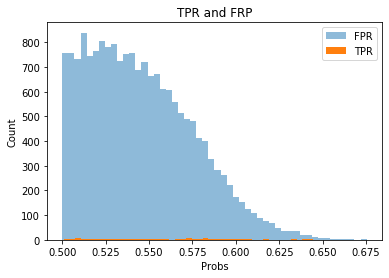

In [158]:
from matplotlib import pyplot
bins = 50
pyplot.hist(fpr_df[fpr_df['class'] == 0].probs, bins, label='FPR',alpha = 0.5)
pyplot.hist(fpr_df[fpr_df['class'] == 1].probs, bins, label='TPR')
pyplot.legend(loc='upper right')
pyplot.title('TPR and FRP')
pyplot.ylabel('Count')
pyplot.xlabel('Probs')
pyplot.show()

In [160]:
X_train.head()

,sale/sale,sale/at,sale/sale_flag,sale/at_flag,at/sale,at/at,at/sale_flag,at/at_flag,act/sale,act/at,...,txt/sale_flag,txt/at_flag,xint/sale,xint/at,xint/sale_flag,xint/at_flag,prcc_f/sale,prcc_f/at,prcc_f/sale_flag,prcc_f/at_flag
1,1.0,1.361683,0,0,0.734385,1.0,0,0,0.545042,0.742175,...,0,0,0.032109,0.043722,0,0,0.018465,0.025143,0,0
2,1.0,1.428408,0,0,0.700080,1.0,0,0,0.495408,0.707644,...,0,0,0.023040,0.032910,0,0,0.024974,0.035673,0,0
3,1.0,1.376801,0,0,0.726321,1.0,0,0,0.521222,0.717620,...,0,0,0.021179,0.029159,0,0,0.045252,0.062303,0,0
4,1.0,1.365206,0,0,0.732490,1.0,0,0,0.524201,0.715642,...,0,0,0.019176,0.026179,0,0,0.030625,0.041810,0,0
5,1.0,1.272922,0,0,0.785594,1.0,0,0,0.564503,0.718568,...,0,0,0.022032,0.028045,0,0,0.022608,0.028778,0,0


### Correlation Analysis of ratio data

In [163]:
import seaborn as sns
def df_corr(df,display = True):
    corr_matrix = df.corr()
    if display:
        plt.subplots(figsize=(35, 35))
        sns.heatmap(corr_matrix, annot=True)
        plt.show()
    return corr_matrix

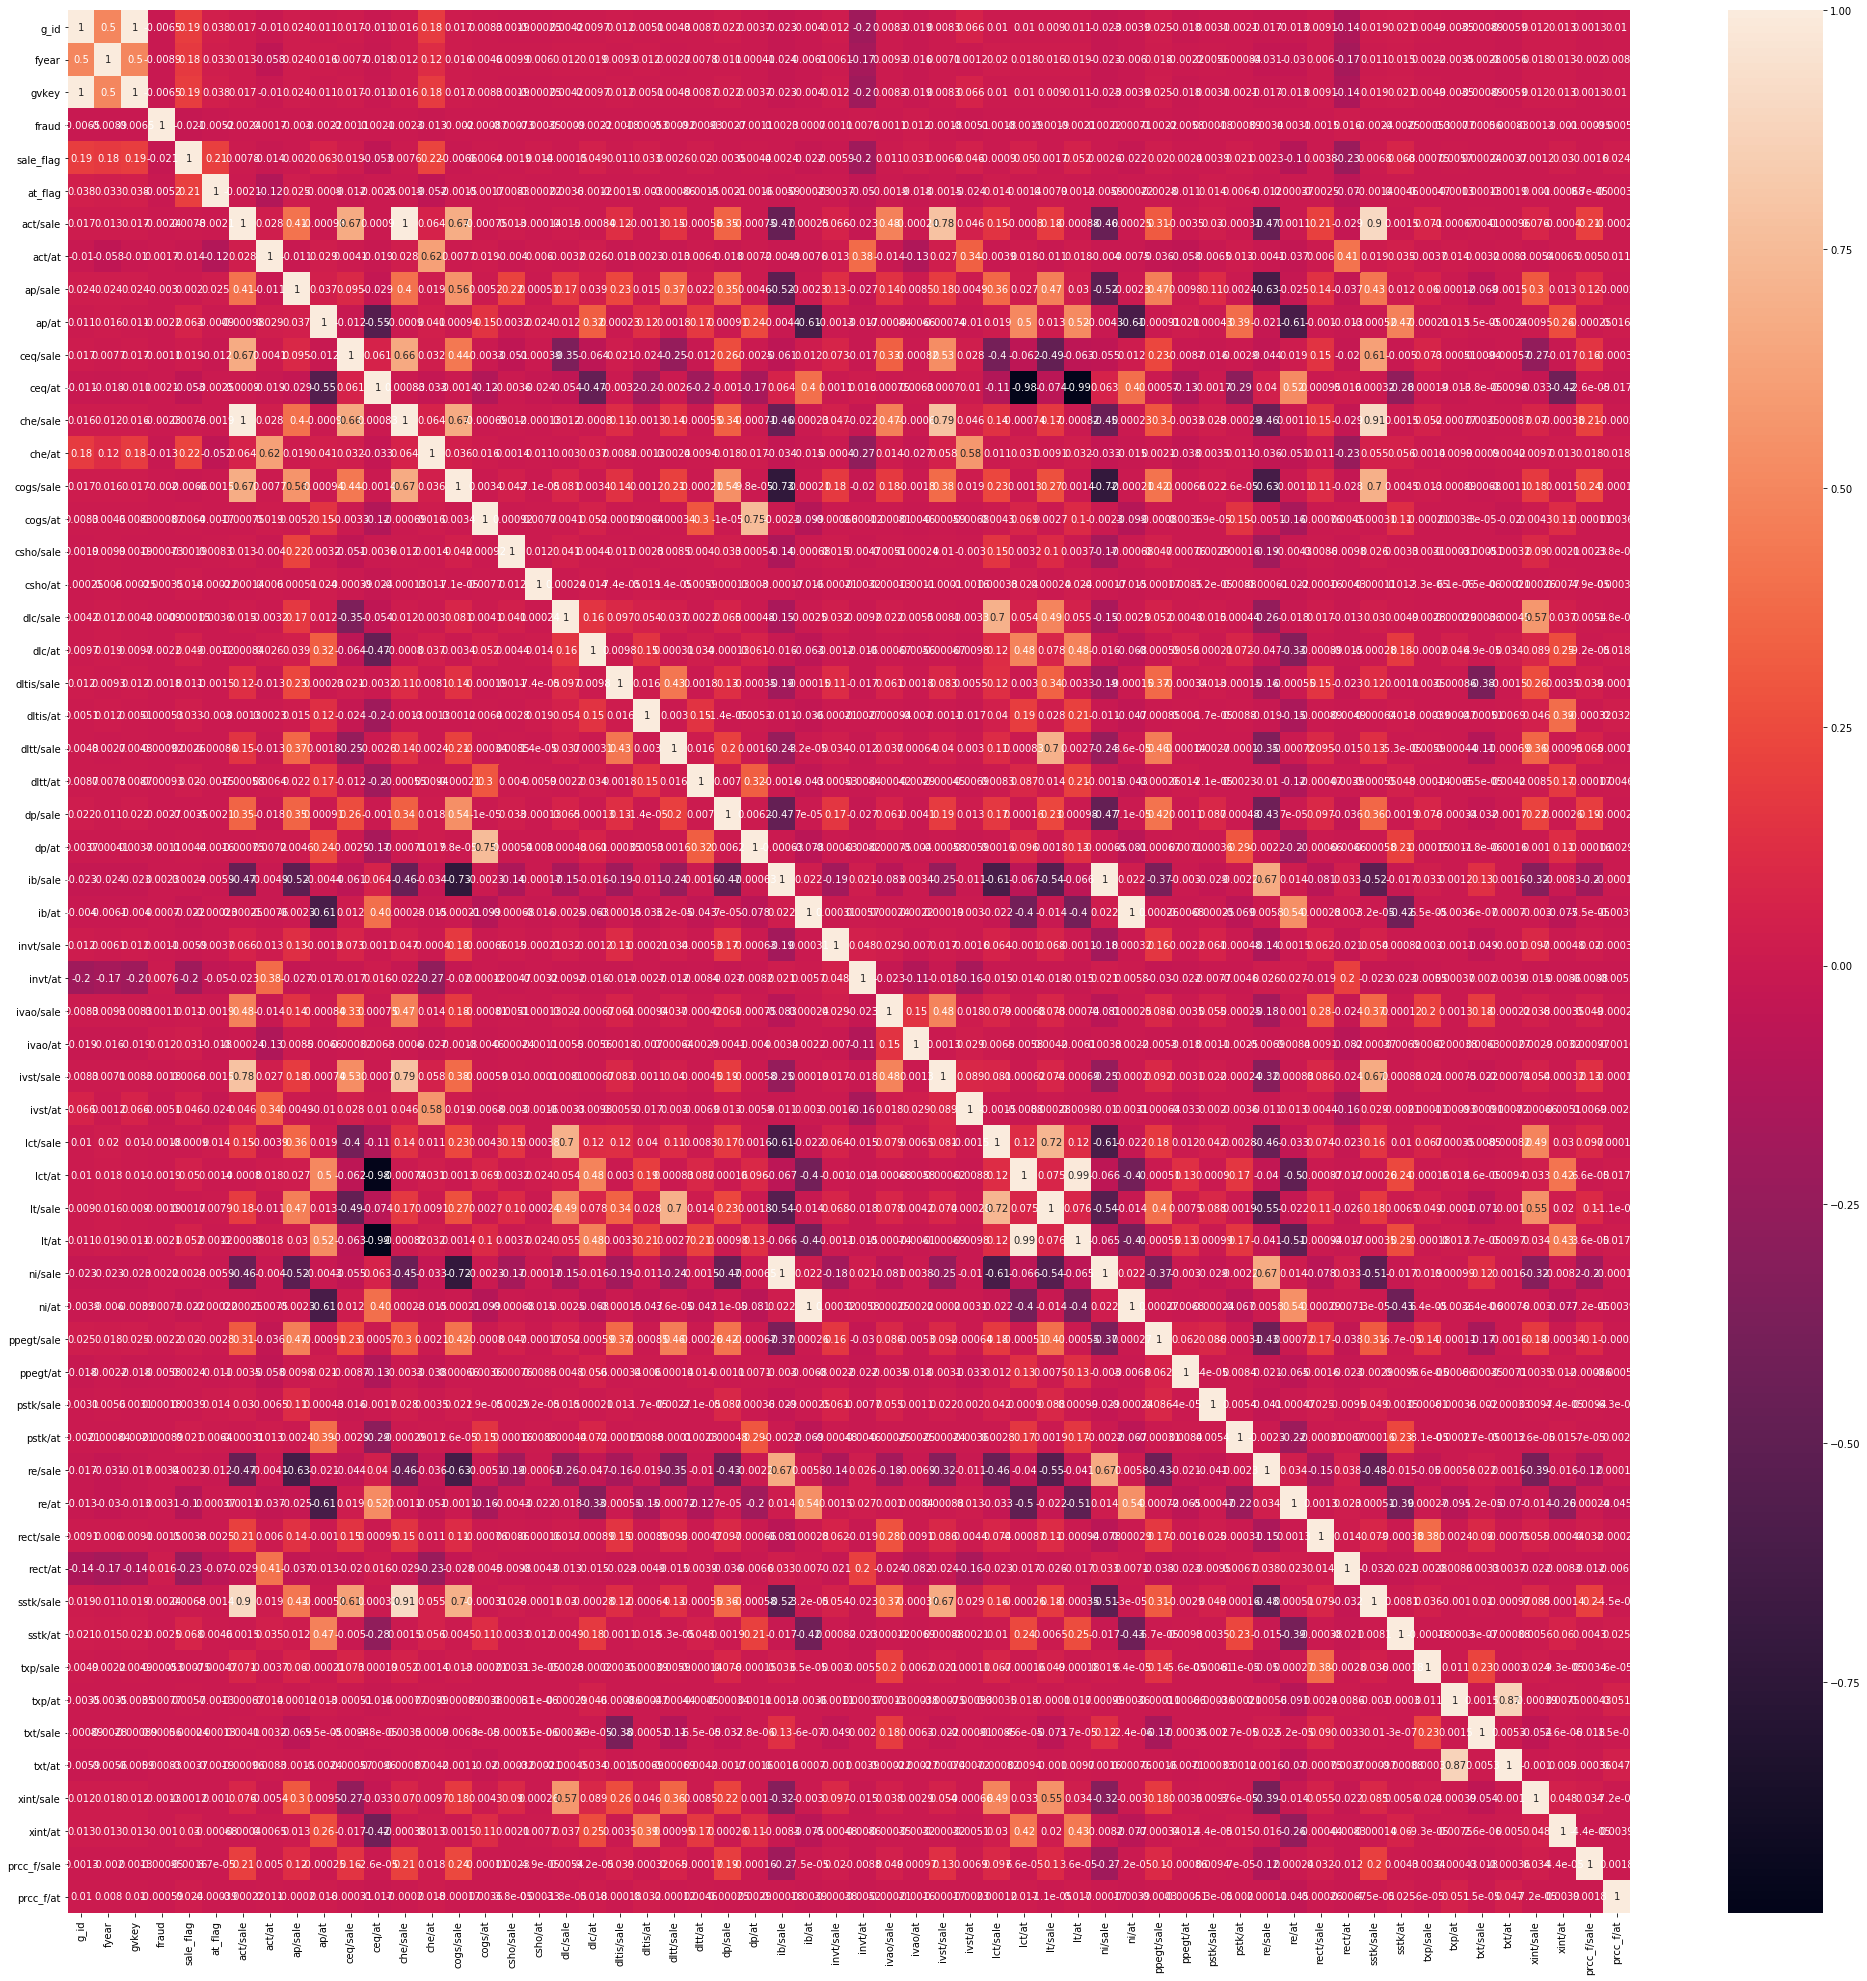

,g_id,fyear,gvkey,fraud,sale_flag,at_flag,act/sale,act/at,ap/sale,ap/at,...,sstk/sale,sstk/at,txp/sale,txp/at,txt/sale,txt/at,xint/sale,xint/at,prcc_f/sale,prcc_f/at
g_id,1.000000,0.498714,1.000000,-0.006475,0.191961,0.038277,0.017030,-0.010201,0.023893,0.011162,...,0.018786,2.093043e-02,0.004944,-0.003522,-8.947372e-04,-0.005912,0.012177,0.013220,0.001335,0.010328
fyear,0.498714,1.000000,0.498714,-0.008860,0.176062,0.033041,0.013004,-0.057521,0.023868,0.015882,...,0.011242,1.520546e-02,0.002171,-0.003516,-2.751409e-03,-0.005601,0.017632,0.013190,-0.001981,0.007986
gvkey,1.000000,0.498714,1.000000,-0.006475,0.191961,0.038277,0.017030,-0.010201,0.023893,0.011162,...,0.018786,2.093043e-02,0.004944,-0.003522,-8.947372e-04,-0.005912,0.012177,0.013220,0.001335,0.010328
fraud,-0.006475,-0.008860,-0.006475,1.000000,-0.020601,-0.005196,-0.002354,0.001732,-0.002997,-0.002169,...,-0.002426,-2.474548e-03,-0.000527,0.000769,5.596023e-04,0.000825,-0.001302,-0.001050,-0.000955,-0.000588
sale_flag,0.191961,0.176062,0.191961,-0.020601,1.000000,0.205860,0.007769,-0.013603,0.002046,0.063096,...,0.006839,6.807072e-02,-0.000755,0.005719,2.416304e-04,-0.003747,-0.001210,0.030377,-0.001608,0.024038
at_flag,0.038277,0.033041,0.038277,-0.005196,0.205860,1.000000,-0.002143,-0.115550,0.025037,-0.000900,...,-0.001368,4.646973e-03,-0.000472,-0.001340,1.285040e-04,-0.001886,0.001027,-0.000681,0.000087,-0.000385
act/sale,0.017030,0.013004,0.017030,-0.002354,0.007769,-0.002143,1.000000,0.028380,0.412870,-0.000977,...,0.903808,1.521452e-03,0.071182,-0.000673,4.083461e-03,-0.000955,0.076446,-0.000404,0.206124,-0.000221
act/at,-0.010201,-0.057521,-0.010201,0.001732,-0.013603,-0.115550,0.028380,1.000000,-0.011231,0.028587,...,0.019309,3.526515e-02,-0.003668,0.014445,3.247463e-03,0.008332,-0.005448,0.006456,0.005007,0.011330
ap/sale,0.023893,0.023868,0.023893,-0.002997,0.002046,0.025037,0.412870,-0.011231,1.000000,0.036823,...,0.427664,1.235914e-02,0.059856,0.000116,-6.918162e-02,-0.001485,0.302587,0.012818,0.119662,-0.000196
ap/at,0.011162,0.015882,0.011162,-0.002169,0.063096,-0.000900,-0.000977,0.028587,0.036823,1.000000,...,-0.000521,4.735034e-01,-0.000207,0.012745,5.503486e-05,-0.002425,0.009530,0.255099,-0.000249,0.016310


In [167]:
df_corr(df)